# Librería Ruptures - Detección de Puntos de Cambio

La librería `ruptures` es una herramienta poderosa para detectar cambios estructurales en series temporales. En finanzas es útil para:

- **Detectar cambios de régimen** en volatilidad o correlaciones
- **Identificar crisis financieras** o eventos importantes
- **Segmentar períodos** para análisis separados
- **Detectar cambios en tendencias** de precios

## Conceptos clave:
- **Change point**: Momento en el tiempo donde cambian las propiedades estadísticas de la serie
- **Cost function**: Función que mide la "homogeneidad" de un segmento
- **Penalty**: Parámetro que controla cuántos puntos de cambio detectar

## Principales algoritmos:
- `Pelt`: Rápido y eficiente para series largas
- `Dynp`: Programación dinámica, más preciso pero lento
- `BottomUp`: Método jerárquico
- `Window`: Ventana deslizante

## Librerías

In [1]:

import pandas as pd
import numpy as np
import random

import requests
from bs4 import BeautifulSoup
import ruptures as rpt
import yfinance as yf


import matplotlib.pyplot as plt

In [ ]:

# =====================================
# EJEMPLO 1: Detectar cambios en precios de una acción
# =====================================

# Descargar datos de AAPL desde 2020
aapl_data = yf.download("AAPL", start="2020-01-01", auto_adjust=True)['Close']

# Convertir a retornos logarítmicos (más estables para análisis)
returns = np.log(aapl_data / aapl_data.shift(1)).dropna()

# Configurar el detector de puntos de cambio
# - model="rbf": Detecta cambios en la media y varianza
# - min_size=30: Mínimo 30 días entre cambios
min_size=30
algo = rpt.Pelt(model="rbf", min_size=min_size).fit(returns.values)

# Detectar puntos de cambio (penalty controla sensibilidad)
# Penalty más alto = menos puntos de cambio
penalty = 10  # Experimenta con valores entre 5-20, 10
change_points = algo.predict(pen=penalty)

# Los índices se refieren a posiciones en el array, convertir a fechas
change_dates = [returns.index[cp-1] for cp in change_points[:-1]]  # -1 porque el último es el final

print(f"Puntos de cambio detectados en AAPL:")
for i, date in enumerate(change_dates):
    print(f"{i+1}. {date.strftime('%Y-%m-%d')}")

# Graficar resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico 1: Precios con puntos de cambio
ax1.plot(aapl_data.index, aapl_data, label='Precio AAPL', linewidth=1)
for date in change_dates:
    ax1.axvline(x=date, color='red', linestyle='--', alpha=0.7)
ax1.set_title('Precios de AAPL con Puntos de Cambio Detectados')
ax1.set_ylabel('Precio ($)')
ax1.legend()
ax1.grid(True)

# Gráfico 2: Retornos con puntos de cambio
ax2.plot(returns.index, returns, label='Retornos log', linewidth=0.8, alpha=0.7)
for date in change_dates:
    ax2.axvline(x=date, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Retornos Logarítmicos con Puntos de Cambio')
ax2.set_ylabel('Retorno log')
ax2.set_xlabel('Fecha')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Cambios en volatilidad detectados:
1. 2020-02-28 - Vol antes: 0.0199, después: 0.0499
2. 2020-05-04 - Vol antes: 0.0409, después: 0.0175
3. 2020-07-29 - Vol antes: 0.0175, después: 0.0276
4. 2020-09-02 - Vol antes: 0.0272, después: 0.0333
5. 2020-10-01 - Vol antes: 0.0339, después: 0.0264
6. 2020-11-27 - Vol antes: 0.0259, después: 0.0165
7. 2021-01-05 - Vol antes: 0.0165, después: 0.0213
8. 2021-04-01 - Vol antes: 0.0230, después: 0.0157
9. 2021-06-07 - Vol antes: 0.0151, después: 0.0110
10. 2021-12-02 - Vol antes: 0.0118, después: 0.0188
11. 2022-05-04 - Vol antes: 0.0180, después: 0.0297
12. 2022-06-09 - Vol antes: 0.0306, después: 0.0259
13. 2022-07-11 - Vol antes: 0.0257, después: 0.0174
14. 2022-09-13 - Vol antes: 0.0159, después: 0.0229
15. 2022-11-01 - Vol antes: 0.0240, después: 0.0308
16. 2022-12-07 - Vol antes: 0.0308, después: 0.0206
17. 2023-01-23 - Vol antes: 0.0204, después: 0.0157
18. 2023-03-21 - Vol antes: 0.0157, después: 0.0127
19. 2023-06-01 - Vol antes: 0.0138, d

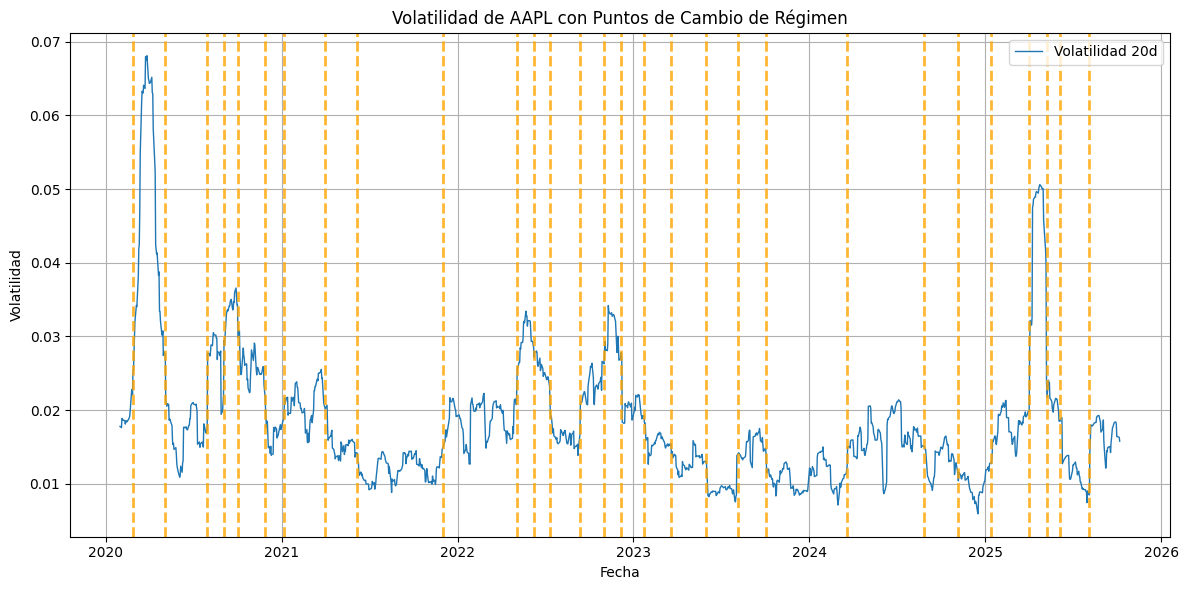

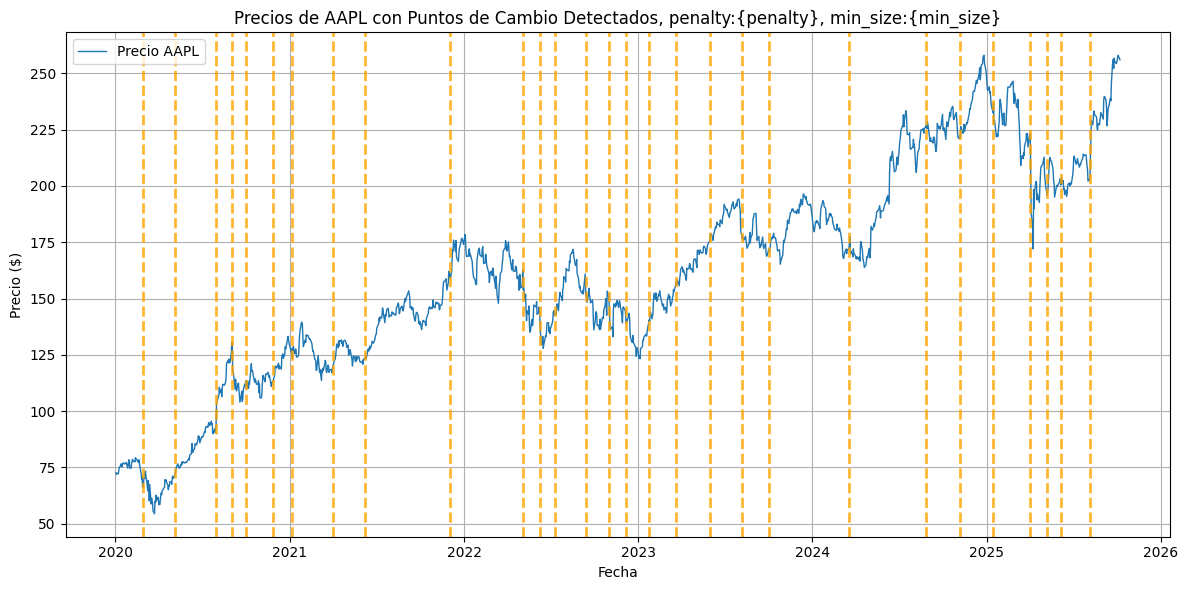

In [ ]:
# =====================================
# EJEMPLO 2: Detectar cambios en VOLATILIDAD
# =====================================

# Calcular volatilidad rolling de 20 días
volatility = returns.rolling(window=20).std().dropna()

# Detector específico para cambios en varianza
algo_var = rpt.Pelt(model="rbf", min_size=20).fit(volatility.values)
vol_changes = algo_var.predict(pen=5)
vol_change_dates = [volatility.index[cp-1] for cp in vol_changes[:-1]]

# Corrected code
print(f"\nCambios en volatilidad detectados:")
for i, date in enumerate(vol_change_dates):
    # Get data before and after the change point
    data_before = volatility.loc[:date]
    data_after = volatility.loc[date:]
    
    # Calculate mean volatility before change point
    if len(data_before) >= 20:
        vol_before = data_before.iloc[-20:].mean()
    else:
        vol_before = data_before.mean()
    
    # Calculate mean volatility after change point  
    if len(data_after) >= 20:
        vol_after = data_after.iloc[:20].mean()
    else:
        vol_after = data_after.mean()
    
    # Convert to scalar if still Series (safety check)
    if hasattr(vol_before, 'item'):
        vol_before = vol_before.item()
    if hasattr(vol_after, 'item'):
        vol_after = vol_after.item()
    
    print(f"{i+1}. {date.strftime('%Y-%m-%d')} - Vol antes: {vol_before:.4f}, después: {vol_after:.4f}")


# Graficar volatilidad con cambios
plt.figure(figsize=(12, 6))

plt.plot(volatility.index, volatility, label='Volatilidad 20d', linewidth=1)
for date in vol_change_dates:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.8, linewidth=2)
plt.title('Volatilidad de AAPL con Puntos de Cambio de Régimen')
plt.ylabel('Volatilidad')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#hacemos un segundo plot para mostrar aapl_data

plt.figure(figsize=(12, 6))

plt.plot(aapl_data.index, aapl_data, label='Precio AAPL', linewidth=1)
for date in vol_change_dates:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.8, linewidth=2)
plt.title('Precios de AAPL con Puntos de Cambio Detectados, penalty:{penalty}, min_size:{min_size}')
plt.ylabel('Precio ($)')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# convertir aapl_data en array numpy
aapl_array = aapl_data.values

# Usamos el modelo 'l2' que detecta cambios en la media
model = "l2"
algo = rpt.KernelCPD(kernel="linear").fit(aapl_array.reshape(-1, 1))

# Detectamos 2 cambios
n_bkps = 2
result = algo.predict(n_bkps=n_bkps)

# Mostrar resultado
rpt.display(aapl_array, result)
plt.title("Puntos de cambio detectados en AAPL")
plt.show()

print("Cambios detectados en:", result)
print(f"Modelo usado: {model}")

In [ ]:
# Ejemplo simple: calculamos los intervalos entre cambios
# y asumimos que se repite el patrón

bkps = result  # por ejemplo: [100, 200, 300]
intervalos = np.diff([0] + bkps)  # [100, 100, 100]

# Si el patrón continúa, predecimos:
proximo_cambio = bkps[-1] + intervalos[-1]
print(f"Predicción ingenua: próximo cambio en el índice {proximo_cambio}")

# Modelos Disponibles en Ruptures

La librería `ruptures` ofrece diferentes modelos según el tipo de cambio que quieras detectar:

## 1. **Modelos por Algoritmo**

### A) Algoritmos con diferentes modelos:
- **`rpt.Pelt(model="...")`** - Más rápido
- **`rpt.Dynp(model="...")`** - Más preciso pero lento
- **`rpt.BottomUp(model="...")`** - Método jerárquico
- **`rpt.Window(model="...")`** - Ventana deslizante

### B) Modelos disponibles:
- **`"l1"`** - Detecta cambios en la **media** (norma L1)
- **`"l2"`** - Detecta cambios en la **media** (norma L2) - **MÁS COMÚN**
- **`"rbf"`** - Detecta cambios en **media y varianza** - **MUY ÚTIL**
- **`"linear"`** - Detecta cambios **lineales**
- **`"normal"`** - Asume distribución normal
- **`"ar"`** - Para series **autorregresivas**
- **`"rank"`** - Detecta cambios en la **mediana**

## 2. **Algoritmos especializados con kernels**

### A) KernelCPD (Change Point Detection con kernels):
```python
rpt.KernelCPD(kernel="linear")    # Cambios lineales
rpt.KernelCPD(kernel="rbf")       # Cambios no lineales (RBF)
rpt.KernelCPD(kernel="cosine")    # Basado en coseno
```

### B) Binseg (Binary Segmentation):
```python
rpt.Binseg(model="l2")   # Segmentación binaria
```

## 3. **Casos de Uso por Modelo**

| Modelo | Mejor para | Ejemplo Financiero |
|--------|------------|-------------------|
| `"l2"` | Cambios en media | Cambios de tendencia en precios |
| `"rbf"` | Cambios en media Y varianza | Crisis financieras, cambios de volatilidad |
| `"normal"` | Datos con distribución normal | Retornos de acciones estables |
| `"rank"` | Datos con outliers | Precios con eventos extremos |
| `"ar"` | Series temporales autorregresivas | Índices bursátiles |
| `"linear"` | Cambios de tendencia lineal | Crecimiento/decrecimiento sostenido |

🔍 COMPARACIÓN DE MODELOS RUPTURES

📊 L2 (media):
   Puntos de cambio: 39
   Fechas: ['2020-03', '2020-05', '2020-06']

📊 RBF (media+var):
   Puntos de cambio: 8
   Fechas: ['2020-07', '2021-06', '2021-11']

📊 Normal:
   Puntos de cambio: 36
   Fechas: ['2020-02', '2020-05', '2020-06']


C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\ruptures\costs\costnormal.py:28: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(



📊 Rank (mediana):
   Puntos de cambio: 6
   Fechas: ['2020-08', '2021-06', '2021-11']

📊 KernelCPD Linear:
   Puntos de cambio: 3
   Fechas: ['2020-08', '2023-03', '2024-06']

📊 KernelCPD RBF:
   Puntos de cambio: 3
   Fechas: ['2020-08', '2023-03', '2024-06']


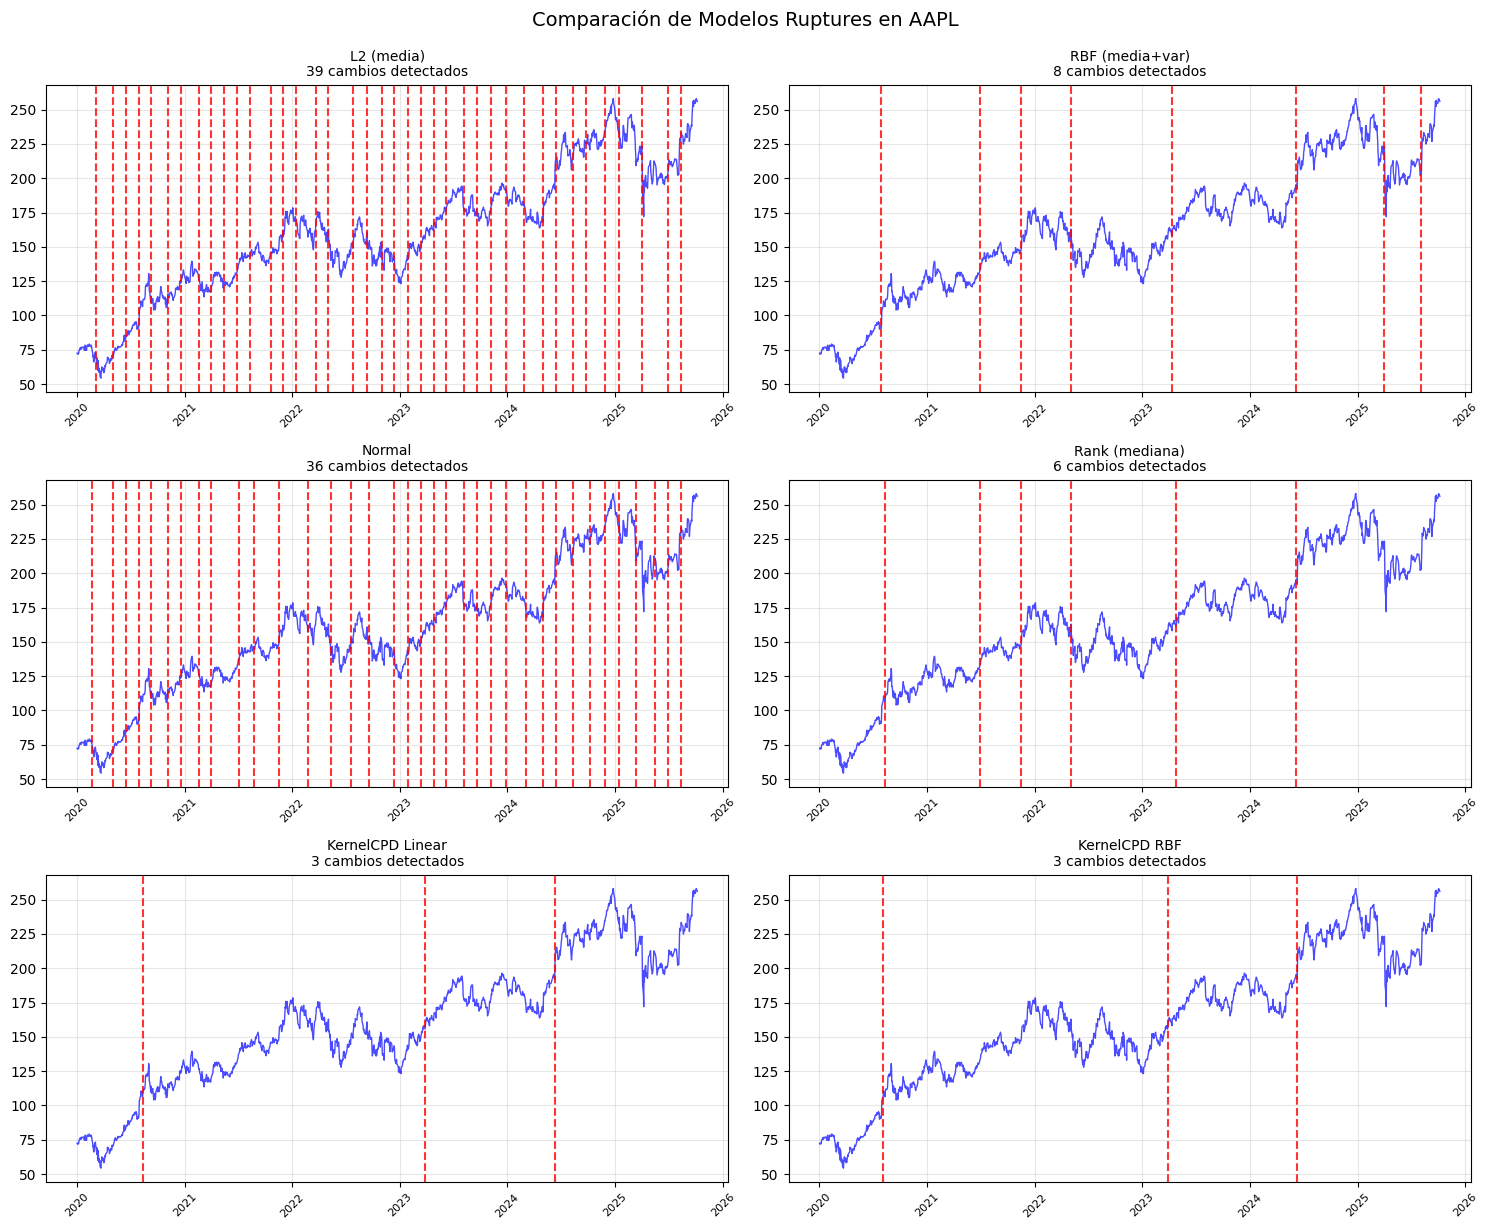


💡 RECOMENDACIONES:
• Para detectar cambios de TENDENCIA: usa 'l2' o 'linear'
• Para detectar CRISIS/VOLATILIDAD: usa 'rbf' o 'normal'
• Para datos con OUTLIERS: usa 'rank'
• Para FLEXIBILIDAD: usa KernelCPD con 'rbf'


In [ ]:
# =======================================================
# COMPARACIÓN DE DIFERENTES MODELOS EN RUPTURES
# =======================================================

import ruptures as rpt
import matplotlib.pyplot as plt
import numpy as np

# Usar los datos de AAPL que ya tenemos
data_to_analyze = aapl_array

# Lista de modelos a comparar
modelos = {
    'L2 (media)': {'type': 'Pelt', 'model': 'l2'},
    'RBF (media+var)': {'type': 'Pelt', 'model': 'rbf'}, 
    'Normal': {'type': 'Pelt', 'model': 'normal'},
    'Rank (mediana)': {'type': 'Pelt', 'model': 'rank'},
    'KernelCPD Linear': {'type': 'KernelCPD', 'kernel': 'linear'},
    'KernelCPD RBF': {'type': 'KernelCPD', 'kernel': 'rbf'}
}

# Parámetros
n_bkps = 3  # Número de puntos de cambio a detectar
min_size = 30

# Crear subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Datos originales para referencia
original_dates = aapl_data.index

print("🔍 COMPARACIÓN DE MODELOS RUPTURES")
print("=" * 50)

for idx, (nombre, config) in enumerate(modelos.items()):
    ax = axes[idx]
    
    try:
        # Configurar algoritmo según el tipo
        if config['type'] == 'KernelCPD':
            algo = rpt.KernelCPD(kernel=config['kernel']).fit(data_to_analyze.reshape(-1, 1))
            change_points = algo.predict(n_bkps=n_bkps)
        else:
            algo = rpt.Pelt(model=config['model'], min_size=min_size).fit(data_to_analyze)
            change_points = algo.predict(pen=10)  # penalty fijo para comparación
        
        # Convertir índices a fechas
        change_dates = [original_dates[cp-1] for cp in change_points[:-1] if cp-1 < len(original_dates)]
        
        # Graficar
        ax.plot(original_dates, data_to_analyze, color='blue', alpha=0.7, linewidth=1)
        
        # Agregar líneas verticales en puntos de cambio
        for date in change_dates:
            ax.axvline(x=date, color='red', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{nombre}\n{len(change_dates)} cambios detectados', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        # Imprimir resultados
        print(f"\n📊 {nombre}:")
        print(f"   Puntos de cambio: {len(change_dates)}")
        if change_dates:
            print(f"   Fechas: {[d.strftime('%Y-%m') for d in change_dates[:3]]}")
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{nombre}\nError en ejecución', fontsize=10)
        print(f"\n❌ {nombre}: Error - {str(e)}")

plt.tight_layout()
plt.suptitle('Comparación de Modelos Ruptures en AAPL', fontsize=14, y=1.02)
plt.show()

print(f"\n💡 RECOMENDACIONES:")
print(f"• Para detectar cambios de TENDENCIA: usa 'l2' o 'linear'")
print(f"• Para detectar CRISIS/VOLATILIDAD: usa 'rbf' o 'normal'") 
print(f"• Para datos con OUTLIERS: usa 'rank'")
print(f"• Para FLEXIBILIDAD: usa KernelCPD con 'rbf'")

📈 MODELO L2 - Cambios de Tendencia
----------------------------------------
1. 2020-03-06 - Posible cambio de tendencia
2. 2020-05-04 - Posible cambio de tendencia
3. 2020-06-16 - Posible cambio de tendencia
4. 2020-07-29 - Posible cambio de tendencia
5. 2020-09-10 - Posible cambio de tendencia
6. 2020-11-05 - Posible cambio de tendencia
7. 2020-12-18 - Posible cambio de tendencia
8. 2021-02-18 - Posible cambio de tendencia
9. 2021-04-01 - Posible cambio de tendencia
10. 2021-05-14 - Posible cambio de tendencia
11. 2021-06-28 - Posible cambio de tendencia
12. 2021-08-10 - Posible cambio de tendencia
13. 2021-10-20 - Posible cambio de tendencia
14. 2021-12-02 - Posible cambio de tendencia
15. 2022-01-14 - Posible cambio de tendencia
16. 2022-03-22 - Posible cambio de tendencia
17. 2022-05-04 - Posible cambio de tendencia
18. 2022-07-25 - Posible cambio de tendencia
19. 2022-09-13 - Posible cambio de tendencia
20. 2022-11-01 - Posible cambio de tendencia
21. 2022-12-14 - Posible cambio d

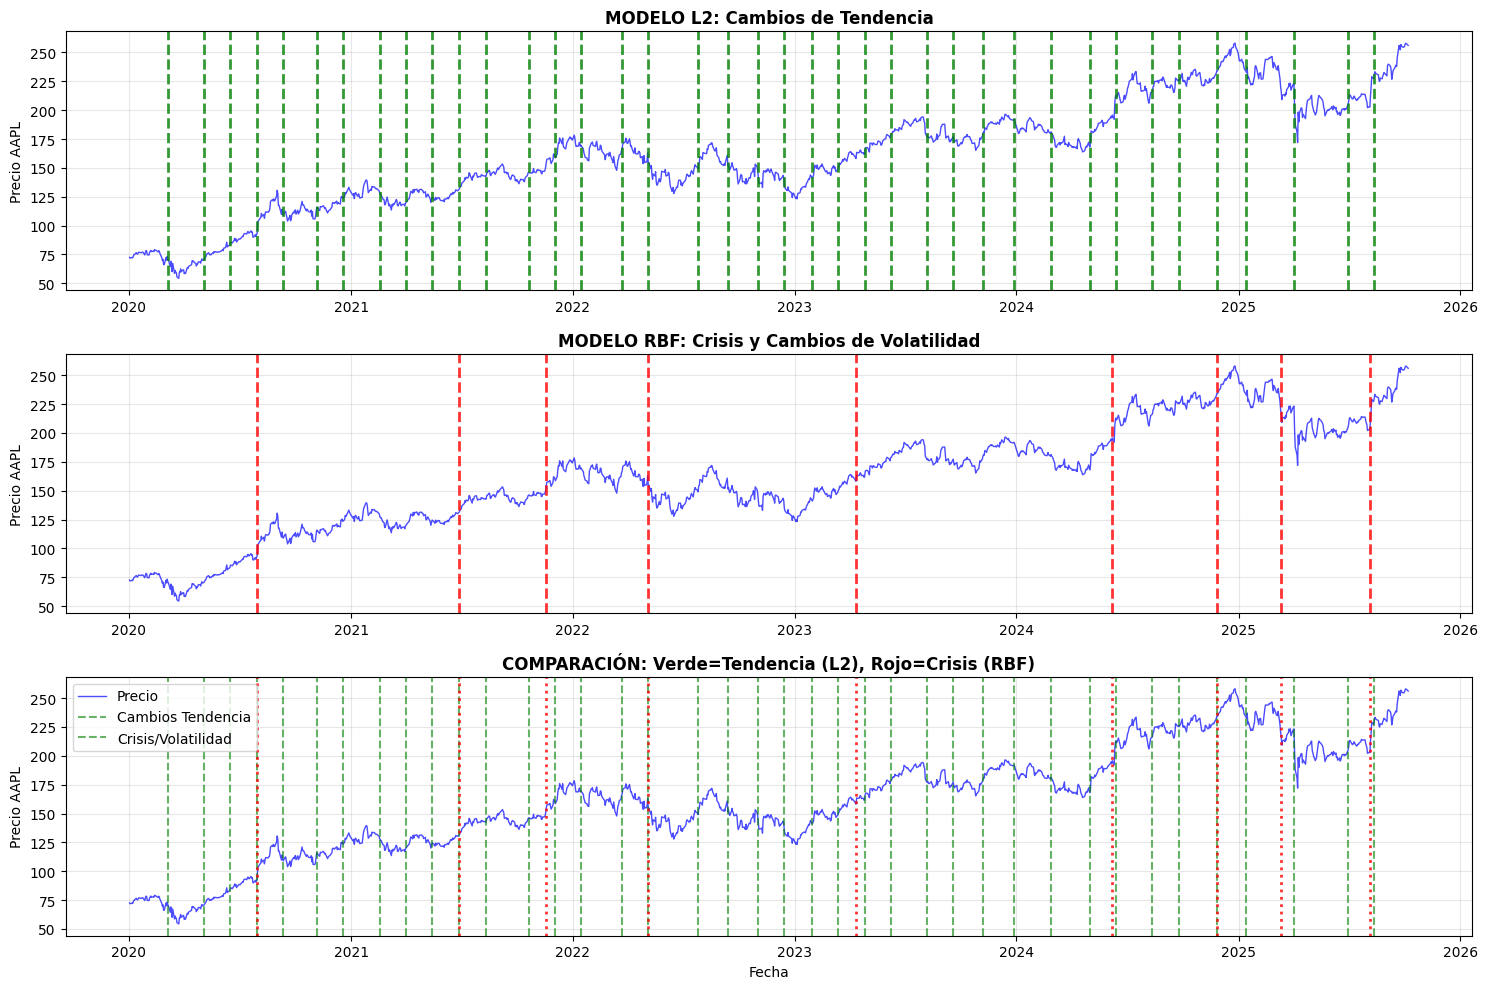


💡 INTERPRETACIÓN:
 Líneas VERDES (L2): Cambios graduales de tendencia alcista/bajista
 Líneas ROJAS (RBF): Cambios bruscos, crisis, o cambios de volatilidad


In [ ]:
# =======================================================
# EJEMPLO PRÁCTICO: DIFERENTES MODELOS PARA FINANZAS
# =======================================================

# Ejemplo 1: Detectar cambios de TENDENCIA (modelo l2)
print("📈 MODELO L2 - Cambios de Tendencia")
print("-" * 40)
algo_tendencia = rpt.Pelt(model="l2", min_size=30).fit(aapl_array)
cambios_tendencia = algo_tendencia.predict(pen=15)
fechas_tendencia = [aapl_data.index[cp-1] for cp in cambios_tendencia[:-1]]

for i, fecha in enumerate(fechas_tendencia):
    print(f"{i+1}. {fecha.strftime('%Y-%m-%d')} - Posible cambio de tendencia")

# Ejemplo 2: Detectar CRISIS/VOLATILIDAD (modelo rbf)
print(f"\n🌪️  MODELO RBF - Crisis y Volatilidad")
print("-" * 40)
algo_crisis = rpt.Pelt(model="rbf", min_size=20).fit(aapl_array)
cambios_crisis = algo_crisis.predict(pen=8)  # penalty más bajo = más sensible
fechas_crisis = [aapl_data.index[cp-1] for cp in cambios_crisis[:-1]]

for i, fecha in enumerate(fechas_crisis):
    print(f"{i+1}. {fecha.strftime('%Y-%m-%d')} - Posible crisis o cambio de volatilidad")

# Ejemplo 3: Modelo ROBUSTO para outliers (rank)
print(f"\n🎯 MODELO RANK - Robusto a Outliers")
print("-" * 40)
try:
    algo_robusto = rpt.Pelt(model="rank", min_size=25).fit(aapl_array)
    cambios_robusto = algo_robusto.predict(pen=12)
    fechas_robusto = [aapl_data.index[cp-1] for cp in cambios_robusto[:-1]]
    
    for i, fecha in enumerate(fechas_robusto):
        print(f"{i+1}. {fecha.strftime('%Y-%m-%d')} - Cambio robusto (ignora outliers)")
except Exception as e:
    print(f"Error con modelo rank: {e}")

# Visualización comparativa
plt.figure(figsize=(15, 10))

# Subplot 1: L2 (Tendencia)
plt.subplot(3, 1, 1)
plt.plot(aapl_data.index, aapl_array, color='blue', alpha=0.7, linewidth=1)
for fecha in fechas_tendencia:
    plt.axvline(x=fecha, color='green', linestyle='--', alpha=0.8, linewidth=2)
plt.title('MODELO L2: Cambios de Tendencia', fontweight='bold')
plt.ylabel('Precio AAPL')
plt.grid(True, alpha=0.3)

# Subplot 2: RBF (Crisis)
plt.subplot(3, 1, 2)
plt.plot(aapl_data.index, aapl_array, color='blue', alpha=0.7, linewidth=1)
for fecha in fechas_crisis:
    plt.axvline(x=fecha, color='red', linestyle='--', alpha=0.8, linewidth=2)
plt.title('MODELO RBF: Crisis y Cambios de Volatilidad', fontweight='bold')
plt.ylabel('Precio AAPL')
plt.grid(True, alpha=0.3)

# Subplot 3: Comparación
plt.subplot(3, 1, 3)
plt.plot(aapl_data.index, aapl_array, color='blue', alpha=0.7, linewidth=1, label='Precio AAPL')
for fecha in fechas_tendencia:
    plt.axvline(x=fecha, color='green', linestyle='--', alpha=0.6, linewidth=1.5)
for fecha in fechas_crisis:
    plt.axvline(x=fecha, color='red', linestyle=':', alpha=0.8, linewidth=2)
plt.title('COMPARACIÓN: Verde=Tendencia (L2), Rojo=Crisis (RBF)', fontweight='bold')
plt.ylabel('Precio AAPL')
plt.xlabel('Fecha')
plt.legend(['Precio', 'Cambios Tendencia', 'Crisis/Volatilidad'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETACIÓN:")
print(f" Líneas VERDES (L2): Cambios graduales de tendencia alcista/bajista")
print(f" Líneas ROJAS (RBF): Cambios bruscos, crisis, o cambios de volatilidad")
